In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import json

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/ada_project"
!ls

/content/drive/My Drive/ada_project
ada_project.ipynb			  quotes-2020-china.json.bz2
baseline_w2v_china_trade_2018.json	  quotes-2020-china_trade.json.bz2
china_trade_2018.json			  sentiment_china_trade_2018.json
china_trade_vader_pos_neg_sentiment.json  sentiment_dictionary.csv
china_trade_vader_sentiment.json	  stock_data
china_trade_zero_shot_sentiment.json	  US_China_Baseline.ipynb
LSTM_stock_pred.ipynb			  vader_sentiment.ipynb
quotes-2018-china.json.bz2		  w2v_unsupervised_sentiment.ipynb
quotes-2018-china_trade.json.bz2	  word2vec.model
quotes-2019-china.json.bz2		  zero_shot_sentiment.ipynb
quotes-2019-china_trade.json.bz2


In [3]:
!ls stock_data

BG_data.csv   CSX_data.csv  GM_data.csv   NVDA_data.csv
CAT_data.csv  DE_data.csv   HOG_data.csv  SWKS_data.csv


We load the quotes dataset with positive and negative sentiment probabilities along with the stock dataset.

In [4]:
import matplotlib.pyplot as plt
stocks = ['BG', 'CSX', 'GM', 'NVDA', 'CAT', 'DE', 'HOG', 'SWKS']
stock_name = 'BG'
quotes = pd.read_json('china_trade_vader_pos_neg_sentiment.json', orient='records', lines=True)
stock = pd.read_csv('stock_data/{}_data.csv'.format(stock_name))

We average the sentiment probabilities by day to be able to join with the daily stock data.

In [5]:
quotes_per_day = quotes[['date', 'vader_pos', 'vader_neg']].groupby(['date']).mean()
quotes_per_day.head()

,vader_pos,vader_neg
date,,
2018-01-01,0.061125,0.078625
2018-01-02,0.143818,0.030705
2018-01-03,0.087583,0.091646
2018-01-04,0.133154,0.089462
2018-01-05,0.112897,0.061077


In [6]:
data = quotes_per_day.join(stock.set_index('Date'))
data.head()

,vader_pos,vader_neg,Open,High,Low,Close,Volume,Log_returns,Log_return_onehot
date,,,,,,,,,
2018-01-01,0.061125,0.078625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.143818,0.030705,58.842545,59.542735,58.159851,59.507725,944500.0,NaN,NaN
2018-01-03,0.087583,0.091646,59.849074,61.450770,59.568997,60.785583,2124600.0,0.021247,1.0
2018-01-04,0.133154,0.089462,61.074403,62.325999,61.048146,61.678322,2026900.0,0.014580,1.0
2018-01-05,0.112897,0.061077,61.704588,62.133455,60.873111,61.214455,795500.0,-0.007549,-1.0


In [7]:
data.drop('Log_return_onehot', axis=1, inplace=True)
data.head()

,vader_pos,vader_neg,Open,High,Low,Close,Volume,Log_returns
date,,,,,,,,
2018-01-01,0.061125,0.078625,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.143818,0.030705,58.842545,59.542735,58.159851,59.507725,944500.0,NaN
2018-01-03,0.087583,0.091646,59.849074,61.450770,59.568997,60.785583,2124600.0,0.021247
2018-01-04,0.133154,0.089462,61.074403,62.325999,61.048146,61.678322,2026900.0,0.014580
2018-01-05,0.112897,0.061077,61.704588,62.133455,60.873111,61.214455,795500.0,-0.007549


In [8]:
data = data.reindex(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Log_returns', 'vader_pos', 'vader_neg'])  # Switch the order of features to make easier removal of sentiment features
data.head()

,Open,High,Low,Close,Volume,Log_returns,vader_pos,vader_neg
date,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.061125,0.078625
2018-01-02,58.842545,59.542735,58.159851,59.507725,944500.0,NaN,0.143818,0.030705
2018-01-03,59.849074,61.450770,59.568997,60.785583,2124600.0,0.021247,0.087583,0.091646
2018-01-04,61.074403,62.325999,61.048146,61.678322,2026900.0,0.014580,0.133154,0.089462
2018-01-05,61.704588,62.133455,60.873111,61.214455,795500.0,-0.007549,0.112897,0.061077


Some dates are in the quotes data but not in the stock data or some features like log return are not define in some cases. We decide to fill nan values with bfill method.

In [9]:
np.sum(data.isnull())

Open           259
High           259
Low            259
Close          259
Volume         259
Log_returns    260
vader_pos        0
vader_neg        0
dtype: int64

In [10]:
data.fillna(method='bfill', inplace=True)
np.sum(data.isnull())

Open           0
High           0
Low            0
Close          0
Volume         0
Log_returns    0
vader_pos      0
vader_neg      0
dtype: int64

We define the hyperparameters for the LSTM algorithm, timesteps are the previous days to take into account when forecasting. We can decide to inclue or not sentiment features to assess sentiment analysis improvement.

In [55]:
max_timesteps = len(data)
timesteps = 20
assert timesteps <= max_timesteps, 'Wrong timesteps value'
epochNum = 200
include_sentiment_features = True

We scale the features before training within the range (0,1) and split the data without shuffle since we need to keep time order for forecasting.

In [56]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))  # Scaling the features

split_idx = int(0.9 * len(data))  # 90:10 train:test split, we must keep time order so no sklearn train_test_split

if include_sentiment_features:
    train, test = data.values[:split_idx], data.values[split_idx:]
else:
    train, test = data.values[:split_idx, :6], data.values[split_idx:, :6]

train_time, test_time = data.index.values[timesteps:split_idx], data.index.values[split_idx + timesteps:]

y_train_raw = data.values[timesteps:split_idx, 0]  # We select Open value as true stock value for a given time step
y_true = data.values[split_idx + timesteps:, 0]

train = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(timesteps, len(train)):
    X_train.append(train[i-timesteps:i])    
    y_train.append(train[i, 0])  # We select Open value as true stock value for a given time step                
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))  # Shape (#samples, #timesteps, #features)

In [57]:
X_test = []

test_scaled = sc.transform(test)

for i in range(timesteps, len(test)):
  X_test.append(test_scaled[i-timesteps:i])
X_test, y_true = np.array(X_test), np.array(y_true)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))  # Shape (#samples, #timesteps, #features)

We build our simple LSTM model to predict Open stock value at timestep t+1.

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

regressor = Sequential()
regressor.add(LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
regressor.add(LSTM(units=16))
regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.summary()


regressor.fit(X_train, y_train, batch_size=32, epochs=epochNum)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 32)            5248      
                                                                 
 lstm_13 (LSTM)              (None, 16)                3136      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,401
Trainable params: 8,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
23/23 [==============================] - 3s 6ms/step - loss: 0.0729
Epoch 2/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0084
Epoch 3/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0033
Epoch 4/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0

In [66]:
y_pred = np.zeros((y_true.shape[0], X_test.shape[2]))
y_pred[:, 0] = np.squeeze(regressor.predict(X_test))  # Padding to scale back
y_pred = sc.inverse_transform(y_pred)
y_pred = np.delete(y_pred, np.arange(1, X_test.shape[2]), axis=1)

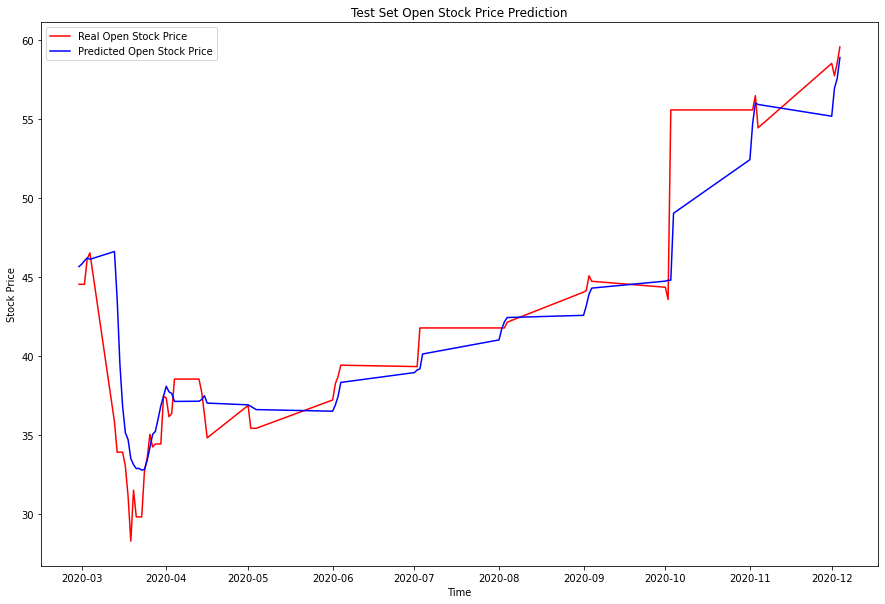

In [67]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(test_time, y_true, color='red', label='Real Open Stock Price')
plt.plot(test_time, y_pred, color='blue', label='Predicted Open Stock Price')
plt.title('Test Set Open Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
# plt.savefig(''.format())

In [68]:
y_train_pred = np.zeros((y_train_raw.shape[0], X_train.shape[2]))
y_train_pred[:, 0] = np.squeeze(regressor.predict(X_train))  # Padding to scale back
y_train_pred = sc.inverse_transform(y_train_pred)
y_train_pred = np.delete(y_train_pred, np.arange(1, X_train.shape[2]), axis=1)

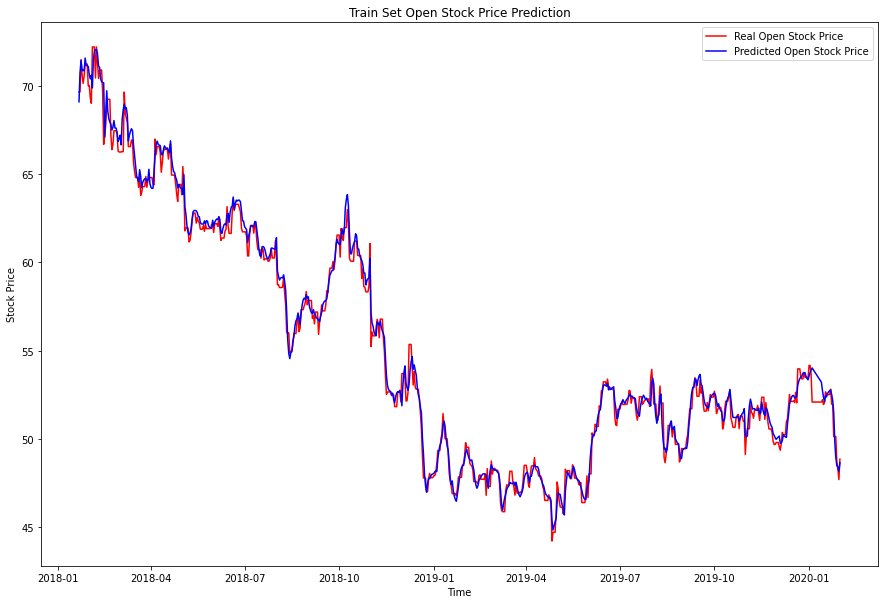

In [69]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(train_time, y_train_raw, color='red', label='Real Open Stock Price')
plt.plot(train_time, y_train_pred, color='blue', label='Predicted Open Stock Price')
plt.title('Train Set Open Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
# plt.savefig(''.format())

In [70]:
import math
from sklearn.metrics import mean_squared_error

rmse_test = math.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE_test = {}".format(rmse_test))
rmse_train = math.sqrt(mean_squared_error(y_train_raw, y_train_pred))
print("RMSE_train = {}".format(rmse_train))

RMSE_test = 2.972818821895873
RMSE_train = 0.5589650566352379


In [71]:
# BG stock with Vader sentiment

RMSE_test = 2.8048925751249034
RMSE_train = 0.5117984277785409
RMSE_test_no_sent = 2.5577450168172526
RMSE_train_no_sent = 0.5248834522340264

RMSE_test_improvement = (RMSE_test_no_sent - RMSE_test) / RMSE_test
RMSE_train_improvement = (RMSE_train_no_sent - RMSE_train) / RMSE_train

print('RMSE_test_improvement = {} %'.format(RMSE_test_improvement * 100))
print('RMSE_train_improvement = {} %'.format(RMSE_train_improvement * 100))

RMSE_test_improvement = -8.811302097608682 %
RMSE_train_improvement = 2.5566753911849704 %
